In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from random import randint
from sklearn.utils import shuffle

In [2]:
data = []
labels = []
dataset_path = './dataset'
imagePaths = list(paths.list_images(dataset_path))
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

In [3]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [4]:
data

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [5]:
labels

array(['Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Disgust', 'Disgust',
       'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust',
       'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust',
       'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust',
       'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust',
       'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust', 'Disgust',
       'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear',
       'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear',
       'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear',
       'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear', 'Fear',
      

In [6]:
# labels 원핫 인코딩
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
# 훈련데이터 테스트데이터 나누기 8:2
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# 훈련데이터 augmentation 객체 초기화
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [7]:
# 초기학습률, epoch, batch size 설정
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [11]:
# VGG16 모델 불러오기, fc계층 False설정, input_tensor설정(input_tensor크기), (분류기)include_top 이 True일 경우 이미지 크기는 사전학습된 모델의 값으로 고정되므로 input_tensor로 변경할 수 없다.
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))



# 베이스모델의 top에 놓여질 head 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)

headModel = Dense(7, activation="softmax")(headModel)
# 헤드 FC모델을 기본 모델 위에 배치 ( 이것이 우리가 훈련할 실제 모델이 됩니다.)
model = Model(inputs=baseModel.input, outputs=headModel)
# 기본 모델의 모든 레이어를 반복하고 고정하여 첫 번째 트레이닝 프로세스 중에 업데이트되지 않도록 합니다.
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# 모델을 컴파일
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# 학습 진행
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100


<ipython-input-12-14a65c6e8f8d>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


32/32 [==============================] - 6s 163ms/step - loss: 2.1274 - accuracy: 0.1434 - val_loss: 1.8351 - val_accuracy: 0.2923
Epoch 2/100
32/32 [==============================] - 2s 58ms/step - loss: 1.8652 - accuracy: 0.2470 - val_loss: 1.7641 - val_accuracy: 0.3231
Epoch 3/100
32/32 [==============================] - 2s 58ms/step - loss: 1.6952 - accuracy: 0.3785 - val_loss: 1.7017 - val_accuracy: 0.4462
Epoch 4/100
32/32 [==============================] - 2s 60ms/step - loss: 1.6367 - accuracy: 0.3705 - val_loss: 1.6297 - val_accuracy: 0.4615
Epoch 5/100
32/32 [==============================] - 2s 60ms/step - loss: 1.5576 - accuracy: 0.4263 - val_loss: 1.6159 - val_accuracy: 0.4462
Epoch 6/100
32/32 [==============================] - 2s 59ms/step - loss: 1.4806 - accuracy: 0.4741 - val_loss: 1.5539 - val_accuracy: 0.4615
Epoch 7/100
32/32 [==============================] - 2s 58ms/step - loss: 1.4483 - accuracy: 0.4661 - val_loss: 1.5296 - val_accuracy: 0.4615
Epoch 8/100
32/32

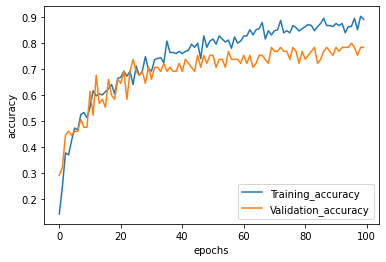

In [13]:
accs = H.history['accuracy']
val_accs = H.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

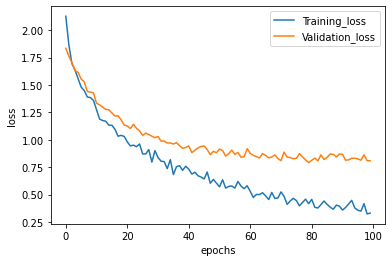

In [14]:
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.plot(range(len(accs)),loss, label = 'Training_loss')
plt.plot(range(len(accs)),val_loss, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

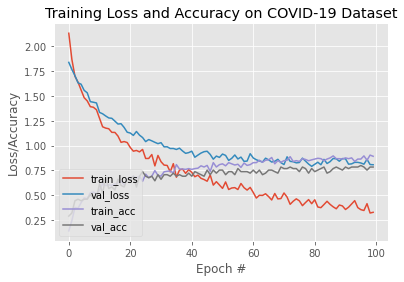

In [15]:
# loss 와 정확도를 시각화
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [16]:
# 테스트셋에서 예측값과 비교
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# 테스트 세트의 각 이미지에 대해 우리는 대응하는 가장 큰 예측 확률을 가진 라벨의 인덱스를 찾아야 한다.
predIdxs = np.argmax(predIdxs, axis=1)
# classification 리포트 시각화
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Anger       0.62      0.83      0.71         6
     Disgust       1.00      0.57      0.73         7
        Fear       0.90      0.82      0.86        11
   Happiness       0.83      0.91      0.87        11
     Neutral       0.89      1.00      0.94         8
     Sadness       0.62      0.73      0.67        11
    Surprise       0.78      0.64      0.70        11

    accuracy                           0.78        65
   macro avg       0.81      0.79      0.78        65
weighted avg       0.80      0.78      0.78        65



In [17]:
# confusion 행렬
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 5  0  0  0  0  1  0]
 [ 2  4  0  0  0  1  0]
 [ 0  0  9  0  0  1  1]
 [ 0  0  0 10  0  1  0]
 [ 0  0  0  0  8  0  0]
 [ 0  0  1  1  0  8  1]
 [ 1  0  0  1  1  1  7]]
acc: 0.1385
sensitivity: 1.0000
specificity: 0.6667
